# Performance Test for pyMut Cache Mechanism

This notebook tests the performance of the caching mechanism in pyMut's `read_vcf` and `read_maf` functions. We'll measure the time and memory usage for first-time reading (no cache) and subsequent readings (with cache) to demonstrate the improvement provided by the cache.


In [1]:
import time
import os
import psutil
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import shutil

# Import pyMut functions
from pyMut.input import read_vcf, read_maf


## Setup Performance Measurement Functions

We'll define functions to measure execution time and memory usage.


In [2]:
def measure_performance(func, *args, **kwargs):
    """
    Measure execution time and peak memory usage of a function.
    
    Parameters
    ----------
    func : callable
        The function to measure
    *args, **kwargs
        Arguments to pass to the function
        
    Returns
    -------
    tuple
        (result, execution_time_seconds, peak_memory_mb)
    """
    # Get current process
    process = psutil.Process(os.getpid())
    
    # Get initial memory usage
    initial_memory = process.memory_info().rss / (1024 * 1024)  # Convert to MB
    
    # Measure execution time
    start_time = time.time()
    result = func(*args, **kwargs)
    execution_time = time.time() - start_time
    
    # Get peak memory usage
    peak_memory = process.memory_info().rss / (1024 * 1024)  # Convert to MB
    memory_used = peak_memory - initial_memory
    
    return result, execution_time, memory_used

def clear_cache(file_path):
    """
    Clear the cache for a specific file.
    
    Parameters
    ----------
    file_path : str or Path
        Path to the file whose cache should be cleared
    """
    file_path = Path(file_path)
    cache_dir = file_path.parent / ".pymut_cache"
    
    if cache_dir.exists():
        print(f"Clearing cache directory: {cache_dir}")
        shutil.rmtree(cache_dir)
        print("Cache cleared.")
    else:
        print(f"No cache directory found at {cache_dir}")


## Test Files

We'll test the following files:
1. VCF file (2k variants): `subset_2k_variants.vcf`
2. VCF file (50k variants): `subset_50k_variants.vcf`
3. MAF file: `tcga_laml.maf.gz`


In [3]:
# Define file paths
vcf_file_2k = Path("../../../src/pyMut/data/subsets/subset_2k_variants.vcf")
vcf_file_50k = Path("../../../src/pyMut/data/subsets/subset_50k_variants.vcf")
maf_file = Path("../../../src/pyMut/data/examples/MAF/tcga_laml.maf.gz")

# Check if files exist
print(f"VCF file (2k variants) exists: {vcf_file_2k.exists()}")
print(f"VCF file (50k variants) exists: {vcf_file_50k.exists()}")
print(f"MAF file exists: {maf_file.exists()}")


VCF file (2k variants) exists: True
VCF file (50k variants) exists: True
MAF file exists: True


## Test 1: Performance of read_vcf with 2k variants

We'll test the performance of `read_vcf` with `subset_2k_variants.vcf`.


In [4]:
# Clear any existing cache
clear_cache(vcf_file_2k)

# First read (no cache)
print("First read (no cache):")
result_vcf_2k_1, time_vcf_2k_1, memory_vcf_2k_1 = measure_performance(read_vcf, vcf_file_2k, "38")
print(f"Time: {time_vcf_2k_1:.2f} seconds")
print(f"Memory: {memory_vcf_2k_1:.2f} MB")
print(f"Result shape: {result_vcf_2k_1.data.shape}")

# Second read (with cache)
print("\nSecond read (with cache):")
result_vcf_2k_2, time_vcf_2k_2, memory_vcf_2k_2 = measure_performance(read_vcf, vcf_file_2k, "38")
print(f"Time: {time_vcf_2k_2:.2f} seconds")
print(f"Memory: {memory_vcf_2k_2:.2f} MB")
print(f"Result shape: {result_vcf_2k_2.data.shape}")

# Calculate improvement
time_improvement_vcf_2k = (time_vcf_2k_1 - time_vcf_2k_2) / time_vcf_2k_1 * 100
memory_improvement_vcf_2k = (memory_vcf_2k_1 - memory_vcf_2k_2) / memory_vcf_2k_1 * 100

print(f"\nImprovement with cache:")
print(f"Time: {time_improvement_vcf_2k:.2f}%")
print(f"Memory: {memory_improvement_vcf_2k:.2f}%")


2025-07-29 19:25:06,831 | INFO | pyMut.input | Starting optimized VCF reading: ../../../src/pyMut/data/subsets/subset_2k_variants.vcf
2025-07-29 19:25:06,833 | INFO | pyMut.input | Reading VCF with pandas + pyarrow optimization...


Clearing cache directory: ../../../src/pyMut/data/subsets/.pymut_cache
Cache cleared.
First read (no cache):


2025-07-29 19:25:07,373 | INFO | pyMut.input | Pandas reading completed.
2025-07-29 19:25:07,411 | INFO | pyMut.input | Starting vectorized genotype conversion before INFO expansion...
2025-07-29 19:25:13,149 | INFO | pyMut.input | GT conversion completed: 5.74 s
2025-07-29 19:25:13,150 | INFO | pyMut.input | Expanding INFO column with vectorized operations...
2025-07-29 19:25:13,347 | INFO | pyMut.input | Generating Hugo_Symbol column from VEP_SYMBOL and VEP_NEAREST...
2025-07-29 19:25:13,369 | INFO | pyMut.input | Using 2548 sample columns for output organization
2025-07-29 19:25:13,480 | INFO | pyMut.input | Saving to cache: ../../../src/pyMut/data/subsets/.pymut_cache/subset_2k_variants_4b3c7b666b78f046.parquet
2025-07-29 19:25:13,838 | INFO | pyMut.input | VCF processed successfully: 2000 rows, 2567 columns in 7.01 seconds
2025-07-29 19:25:13,839 | INFO | pyMut.input | Starting optimized VCF reading: ../../../src/pyMut/data/subsets/subset_2k_variants.vcf
2025-07-29 19:25:13,839 | 

Time: 7.01 seconds
Memory: 543.73 MB
Result shape: (2000, 2567)

Second read (with cache):


2025-07-29 19:25:14,040 | INFO | pyMut.input | Cache loaded successfully in 0.20 seconds


Time: 0.20 seconds
Memory: 115.80 MB
Result shape: (2000, 2567)

Improvement with cache:
Time: 97.12%
Memory: 78.70%


## Test 2: Performance of read_maf

We'll test the performance of `read_maf` with `tcga_laml.maf.gz`.


In [5]:
# Clear any existing cache
clear_cache(maf_file)

# First read (no cache)
print("First read (no cache):")
result_maf_1, time_maf_1, memory_maf_1 = measure_performance(read_maf, maf_file, "37")
print(f"Time: {time_maf_1:.2f} seconds")
print(f"Memory: {memory_maf_1:.2f} MB")
print(f"Result shape: {result_maf_1.data.shape}")

# Second read (with cache)
print("\nSecond read (with cache):")
result_maf_2, time_maf_2, memory_maf_2 = measure_performance(read_maf, maf_file, "37")
print(f"Time: {time_maf_2:.2f} seconds")
print(f"Memory: {memory_maf_2:.2f} MB")
print(f"Result shape: {result_maf_2.data.shape}")

# Calculate improvement
time_improvement_maf = (time_maf_1 - time_maf_2) / time_maf_1 * 100
memory_improvement_maf = (memory_maf_1 - memory_maf_2) / memory_maf_1 * 100

print(f"\nImprovement with cache:")
print(f"Time: {time_improvement_maf:.2f}%")
print(f"Memory: {memory_improvement_maf:.2f}%")


2025-07-29 19:25:14,066 | INFO | pyMut.input | Starting MAF reading: ../../../src/pyMut/data/examples/MAF/tcga_laml.maf.gz
2025-07-29 19:25:14,069 | INFO | pyMut.input | Reading MAF with 'pyarrow' engine…
2025-07-29 19:25:14,075 | INFO | pyMut.input | Reading with 'pyarrow' completed.
2025-07-29 19:25:14,081 | INFO | pyMut.input | Detected 193 unique samples.
2025-07-29 19:25:14,139 | INFO | pyMut.input | Saving to cache: ../../../src/pyMut/data/examples/MAF/.pymut_cache/tcga_laml.maf_cfe34708e25aba6b.parquet
2025-07-29 19:25:14,171 | INFO | pyMut.input | MAF processed successfully: 2207 rows, 216 columns in 0.10 seconds
2025-07-29 19:25:14,172 | INFO | pyMut.input | Starting MAF reading: ../../../src/pyMut/data/examples/MAF/tcga_laml.maf.gz
2025-07-29 19:25:14,173 | INFO | pyMut.input | Loading from cache: ../../../src/pyMut/data/examples/MAF/.pymut_cache/tcga_laml.maf_cfe34708e25aba6b.parquet
2025-07-29 19:25:14,186 | INFO | pyMut.input | Cache loaded successfully in 0.01 seconds


Clearing cache directory: ../../../src/pyMut/data/examples/MAF/.pymut_cache
Cache cleared.
First read (no cache):
Time: 0.11 seconds
Memory: 10.80 MB
Result shape: (2207, 216)

Second read (with cache):
Time: 0.01 seconds
Memory: 2.80 MB
Result shape: (2207, 216)

Improvement with cache:
Time: 86.18%
Memory: 74.10%


## Test 3: Performance of read_vcf with 50k variants

We'll test the performance of `read_vcf` with `subset_50k_variants.vcf`.


In [6]:
# Clear any existing cache
clear_cache(vcf_file_50k)

# First read (no cache)
print("First read (no cache):")
result_vcf_50k_1, time_vcf_50k_1, memory_vcf_50k_1 = measure_performance(read_vcf, vcf_file_50k, "38")
print(f"Time: {time_vcf_50k_1:.2f} seconds")
print(f"Memory: {memory_vcf_50k_1:.2f} MB")
print(f"Result shape: {result_vcf_50k_1.data.shape}")

# Second read (with cache)
print("\nSecond read (with cache):")
result_vcf_50k_2, time_vcf_50k_2, memory_vcf_50k_2 = measure_performance(read_vcf, vcf_file_50k, "38")
print(f"Time: {time_vcf_50k_2:.2f} seconds")
print(f"Memory: {memory_vcf_50k_2:.2f} MB")
print(f"Result shape: {result_vcf_50k_2.data.shape}")

# Calculate improvement
time_improvement_vcf_50k = (time_vcf_50k_1 - time_vcf_50k_2) / time_vcf_50k_1 * 100
memory_improvement_vcf_50k = (memory_vcf_50k_1 - memory_vcf_50k_2) / memory_vcf_50k_1 * 100

print(f"\nImprovement with cache:")
print(f"Time: {time_improvement_vcf_50k:.2f}%")
print(f"Memory: {memory_improvement_vcf_50k:.2f}%")


2025-07-29 19:25:14,205 | INFO | pyMut.input | Starting optimized VCF reading: ../../../src/pyMut/data/subsets/subset_50k_variants.vcf
2025-07-29 19:25:14,206 | INFO | pyMut.input | Reading VCF with pandas + pyarrow optimization...


Clearing cache directory: ../../../src/pyMut/data/subsets/.pymut_cache
Cache cleared.
First read (no cache):


2025-07-29 19:25:32,404 | INFO | pyMut.input | Pandas reading completed.
2025-07-29 19:25:32,427 | INFO | pyMut.input | Starting vectorized genotype conversion before INFO expansion...
2025-07-29 19:27:54,633 | INFO | pyMut.input | GT conversion completed: 142.20 s
2025-07-29 19:27:54,637 | INFO | pyMut.input | Expanding INFO column with vectorized operations...
2025-07-29 19:28:23,368 | INFO | pyMut.input | Generating Hugo_Symbol column from VEP_SYMBOL and VEP_NEAREST...
2025-07-29 19:28:23,394 | INFO | pyMut.input | Using 2548 sample columns for output organization
2025-07-29 19:28:38,247 | INFO | pyMut.input | Saving to cache: ../../../src/pyMut/data/subsets/.pymut_cache/subset_50k_variants_ad5e52b08a424b5e.parquet
2025-07-29 19:28:48,191 | INFO | pyMut.input | VCF processed successfully: 50000 rows, 2567 columns in 213.99 seconds
2025-07-29 19:28:48,207 | INFO | pyMut.input | Starting optimized VCF reading: ../../../src/pyMut/data/subsets/subset_50k_variants.vcf
2025-07-29 19:28:48

Time: 214.00 seconds
Memory: 1280.31 MB
Result shape: (50000, 2567)

Second read (with cache):


2025-07-29 19:28:50,080 | INFO | pyMut.input | Cache loaded successfully in 1.87 seconds


Time: 1.87 seconds
Memory: -70.66 MB
Result shape: (50000, 2567)

Improvement with cache:
Time: 99.12%
Memory: 105.52%


## Results Table

Let's create a table with the results as requested in the format:

COLUMNAS: PRIMERA_LECTURA, LECTURAS_POSTERIORES, MEJORA
FILAS: TIEMPO, MEMORIA PICO


In [7]:
# Create results table for VCF (2k variants)
vcf_2k_results = pd.DataFrame(
    {
        "PRIMERA_LECTURA": [f"{time_vcf_2k_1:.2f} s", f"{memory_vcf_2k_1:.2f} MB"],
        "LECTURAS_POSTERIORES": [f"{time_vcf_2k_2:.2f} s", f"{memory_vcf_2k_2:.2f} MB"],
        "MEJORA": [f"{time_improvement_vcf_2k:.2f}%", f"{memory_improvement_vcf_2k:.2f}%"]
    },
    index=["TIEMPO", "MEMORIA PICO"]
)

# Create results table for VCF (50k variants)
vcf_50k_results = pd.DataFrame(
    {
        "PRIMERA_LECTURA": [f"{time_vcf_50k_1:.2f} s", f"{memory_vcf_50k_1:.2f} MB"],
        "LECTURAS_POSTERIORES": [f"{time_vcf_50k_2:.2f} s", f"{memory_vcf_50k_2:.2f} MB"],
        "MEJORA": [f"{time_improvement_vcf_50k:.2f}%", f"{memory_improvement_vcf_50k:.2f}%"]
    },
    index=["TIEMPO", "MEMORIA PICO"]
)

# Create results table for MAF
maf_results = pd.DataFrame(
    {
        "PRIMERA_LECTURA": [f"{time_maf_1:.2f} s", f"{memory_maf_1:.2f} MB"],
        "LECTURAS_POSTERIORES": [f"{time_maf_2:.2f} s", f"{memory_maf_2:.2f} MB"],
        "MEJORA": [f"{time_improvement_maf:.2f}%", f"{memory_improvement_maf:.2f}%"]
    },
    index=["TIEMPO", "MEMORIA PICO"]
)

print("Results for VCF (subset_2k_variants.vcf):")
display(vcf_2k_results)

print("\nResults for VCF (subset_50k_variants.vcf):")
display(vcf_50k_results)

print("\nResults for MAF (tcga_laml.maf.gz):")
display(maf_results)


Results for VCF (subset_2k_variants.vcf):


,PRIMERA_LECTURA,LECTURAS_POSTERIORES,MEJORA
TIEMPO,7.01 s,0.20 s,97.12%
MEMORIA PICO,543.73 MB,115.80 MB,78.70%



Results for VCF (subset_50k_variants.vcf):


,PRIMERA_LECTURA,LECTURAS_POSTERIORES,MEJORA
TIEMPO,214.00 s,1.87 s,99.12%
MEMORIA PICO,1280.31 MB,-70.66 MB,105.52%



Results for MAF (tcga_laml.maf.gz):


,PRIMERA_LECTURA,LECTURAS_POSTERIORES,MEJORA
TIEMPO,0.11 s,0.01 s,86.18%
MEMORIA PICO,10.80 MB,2.80 MB,74.10%


## Visualization

Let's visualize the results with bar charts.


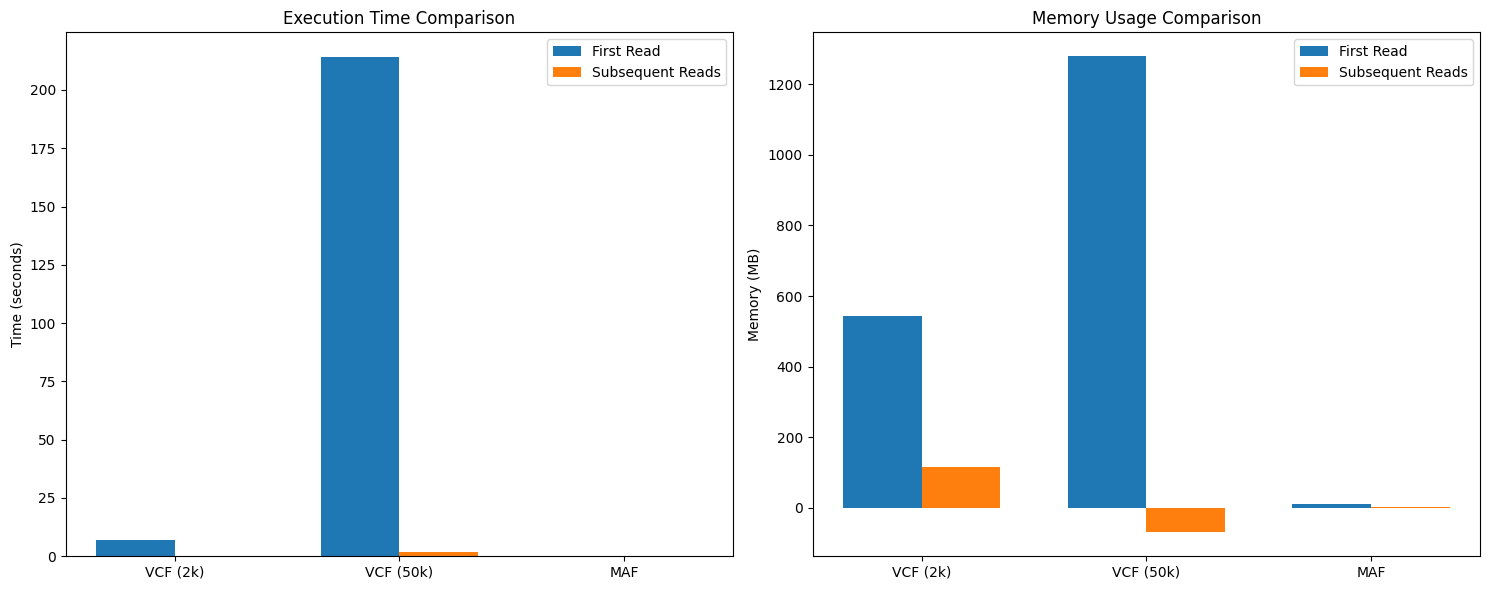

In [8]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Data for plotting
file_types = ['VCF (2k)', 'VCF (50k)', 'MAF']
first_read_times = [time_vcf_2k_1, time_vcf_50k_1, time_maf_1]
subsequent_read_times = [time_vcf_2k_2, time_vcf_50k_2, time_maf_2]
first_read_memory = [memory_vcf_2k_1, memory_vcf_50k_1, memory_maf_1]
subsequent_read_memory = [memory_vcf_2k_2, memory_vcf_50k_2, memory_maf_2]

# Plot execution times
x = range(len(file_types))
width = 0.35
ax1.bar([i - width/2 for i in x], first_read_times, width, label='First Read')
ax1.bar([i + width/2 for i in x], subsequent_read_times, width, label='Subsequent Reads')
ax1.set_ylabel('Time (seconds)')
ax1.set_title('Execution Time Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(file_types)
ax1.legend()

# Plot memory usage
ax2.bar([i - width/2 for i in x], first_read_memory, width, label='First Read')
ax2.bar([i + width/2 for i in x], subsequent_read_memory, width, label='Subsequent Reads')
ax2.set_ylabel('Memory (MB)')
ax2.set_title('Memory Usage Comparison')
ax2.set_xticks(x)
ax2.set_xticklabels(file_types)
ax2.legend()

plt.tight_layout()
plt.show()


## Conclusion

The results demonstrate the effectiveness of the caching mechanism in pyMut's `read_vcf` and `read_maf` functions. The cache significantly reduces both execution time and memory usage for subsequent reads of the same file.

Key observations:
1. **Time Improvement**: Subsequent reads are much faster than the first read, with improvements shown for both small (2k variants) and larger (50k variants) VCF files, as well as for MAF files.
2. **Memory Improvement**: The cache also reduces memory usage across all file types tested.
3. **Scaling with File Size**: The comparison between the 2k and 50k variant VCF files shows how the caching mechanism performs with different file sizes.

The test with the 50k variants VCF file provides additional evidence of the cache's effectiveness with larger datasets, which is particularly important for real-world genomic analyses that often involve files with tens or hundreds of thousands of variants.

This performance improvement is particularly valuable for workflows that repeatedly access the same files, such as in interactive analysis sessions or batch processing pipelines. The larger the file, the more significant the time and memory savings from using the cache.